In [1]:
import os
import re
import pandas as pd
import torch
import torch.nn as nn
import torch_scatter
import torch_geometric
from torch_geometric import data as tg_data
from torch_geometric.data import Dataset, DataLoader
from torch_scatter import scatter,scatter_mean
import e3nn
from e3nn import o3
from e3nn.math import soft_one_hot_linspace
from e3nn.nn import Gate
from e3nn.nn.models.gate_points_2101 import Convolution, smooth_cutoff, tp_path_exists

from tqdm import tqdm
from collections import defaultdict, namedtuple
import pickle
from ase import Atom,Atoms
from ase.neighborlist import neighbor_list
from mendeleev import element
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from pymatgen.core import Structure
import random
import numpy as np

from typing import Dict
import time

import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_scatter import scatter

import matplotlib.pyplot as plt
datasets = ['g', 'y', 'r']
palette = ['#43AA8B', '#F8961E', '#F94144']
colors = dict(zip(datasets, palette))
import math

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pymatgen")

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

torch device: cuda:0


In [4]:
seed = 36
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)
random.seed(seed)

数据读取

In [5]:
def extract_number(file_name):
    match = re.search(r'mp-(\d+)', file_name)
    return int(match.group(1)) if match else float('inf')  # 返回匹配到的数字，未匹配的文件排在最后

# 设置CIF文件夹路径
cif_folder = '../train_set'

# 获取所有CIF文件
cif_files = [f for f in os.listdir(cif_folder) if f.endswith('.cif')]

# 按照文件名中的数字进行升序排序
cif_files.sort(key=lambda x: extract_number(os.path.basename(x)))

In [6]:
df_info = pd.read_excel('../train_set/train_materials_info.xlsx')

df_info['mp_num'] = df_info['Material ID'].apply(lambda x: int(re.search(r'\d+', str(x)).group()))
# 根据提取的数字部分进行排序
df_info_sorted = df_info.sort_values(by='mp_num', ascending=True)

In [7]:
target_column = df_info_sorted.iloc[:, -3] 

In [8]:
# 定义元素属性的命名元组
ElementProperties = namedtuple('ElementProperties', ['mass', 'dipole', 'radius', 'ionization_energy', 'electronegativity'])

# 文件路径定义
DATA_FILE = "./element_data_v2.pkl"

# 加载或初始化元素数据
def load_or_initialize_data(file_path):
    if os.path.exists(file_path):
        return load_data(file_path)
    else:
        return initialize_element_data(file_path)

# 初始化元素数据
def initialize_element_data(file_path):
    type_mapping = {}
    element_attributes = defaultdict(list)

    # 获取所有元素的物理化学属性
    for atomic_number in tqdm(range(1, 119)):  # 遍历元素周期表
        element = Atom(atomic_number)  # 获取元素对象
        element_symbol = element.symbol
        type_mapping[element_symbol] = atomic_number - 1  # 原子类型映射

        # 获取每个元素的物理化学属性
        properties = extract_element_properties(element_symbol)

        # 存储这些属性到字典
        element_attributes['mass'].append(properties.mass)
        element_attributes['dipole'].append(properties.dipole)
        element_attributes['radius'].append(properties.radius)
        element_attributes['ionization_energy'].append(properties.ionization_energy)
        element_attributes['electronegativity'].append(properties.electronegativity)

    # 数据标准化处理（对数值数据）
    element_attributes = standardize_data(element_attributes)

    # 保存初始化的数据
    save_data(file_path, type_mapping, element_attributes)
    return {"type_mapping": type_mapping, **element_attributes}

# 提取元素的物理化学属性
def extract_element_properties(symbol):
    # 获取元素的物理化学属性，部分使用默认值填充
    mass = element(symbol).mass
    dipole = element(symbol).dipole_polarizability or 67.0
    radius = element(symbol).covalent_radius_pyykko
    ionization_energy = element(symbol).ionenergies.get(1, 7.5)
    electronegativity = element(symbol).electronegativity(scale="pauling") or 2.5

    return ElementProperties(mass, dipole, radius, ionization_energy, electronegativity)

# 加载已保存的数据
def load_data(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# 保存数据到文件
def save_data(file_path, type_mapping, element_attributes):
    with open(file_path, 'wb') as f:
        pickle.dump({"type_mapping": type_mapping, **element_attributes}, f)

# 标准化数值数据
def standardize_data(element_attributes):
    scaler = StandardScaler()

    # 对数值特征进行标准化
    standardized_data = {}
    for attribute, values in element_attributes.items():
        if attribute in ["mass", "dipole", "radius", "ionization_energy", "electronegativity"]:
            standardized_data[attribute] = scaler.fit_transform(torch.tensor(values, dtype=torch.float32).view(-1, 1)).squeeze().tolist()
        else:
            standardized_data[attribute] = values

    return standardized_data

# 加载元素数据
data = load_or_initialize_data(DATA_FILE)

type_mapping = data["type_mapping"]
mass_data = data["mass"]
dipole_data = data["dipole"]
radius_data = data["radius"]
ionization_energy_data = data["ionization_energy"]
electronegativity_data = data["electronegativity"]

# 创建原子类型的 one-hot 编码
type_onehot = torch.eye(len(type_mapping))

# 完成后的输出
print("One-hot encoding for atomic types and data standardization complete.")

One-hot encoding for atomic types and data standardization complete.


In [9]:
def calculate_angle(vec1, vec2, eps=1e-5, default_value=torch.tensor(0.0, device=device)):
    dot_product = torch.sum(vec1 * vec2, dim=-1)
    norm_vec1 = torch.norm(vec1, dim=-1)
    norm_vec2 = torch.norm(vec2, dim=-1)
    if norm_vec1.item() == 0 or norm_vec2.item() == 0:
        return default_value
    cos_theta = dot_product / (norm_vec1 * norm_vec2 + eps)
    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
    angle_radians = torch.acos(cos_theta)
    if torch.isnan(angle_radians):
        return default_value
    return angle_radians

In [10]:
def gaussian_process(edge_len, start=0.0, stop=5.0, resolution=50, std=0.5):
    means = torch.linspace(start, stop, resolution, device=edge_len.device) 
    edge_len = edge_len.unsqueeze(-1) 
    means = means.view(1, -1) 
    return torch.exp(-((edge_len - means) ** 2) / (2 * std ** 2))

In [11]:
def compute_weighted_angles(edge_src, edge_dst, edge_vec, edge_len, eps=1e-5):
    """
    向量化计算共享同一中心节点的边的加权平均夹角：
    对于每个边，计算与同一节点其它边（且目的节点不同）的夹角，并根据边长比加权平均。
    """
    weighted_angles = torch.zeros(edge_src.size(0), device=edge_src.device, dtype=torch.float32)
    unique_sources = torch.unique(edge_src)
    for src in unique_sources:
        # 找到同一源节点的所有边索引
        idx = (edge_src == src).nonzero(as_tuple=False).squeeze()
        if idx.dim() == 0:
            idx = idx.unsqueeze(0)
        # 若只有一条边，则没有可比较的角度
        if idx.numel() <= 1:
            continue
        # 取出该组边的向量、边长和目的节点信息
        E = edge_vec[idx]      # shape: (m, d)
        dists = edge_len[idx]  # shape: (m,)
        dests = edge_dst[idx]  # shape: (m,)
        m = E.size(0)
        # 利用矩阵运算计算所有边对的内积和模长外积
        dot = E @ E.T           # shape: (m, m)
        norms = dists
        norms_outer = norms.unsqueeze(1) * norms.unsqueeze(0) + eps
        cos = dot / norms_outer
        cos = torch.clamp(cos, -1.0, 1.0)
        angles = torch.acos(cos)  # shape: (m, m)
        # 计算边长比：对于每对 (i, j) 用 dists[i] / dists[j]
        ratios = dists.unsqueeze(1) / (dists.unsqueeze(0) + eps)
        ratios = torch.clamp(ratios, 0.01, 10)
        weighted = angles * ratios  # 加权角度矩阵
        # 构造 mask：只保留目的节点不同的边对（自动排除自身比较，因为目的节点必然相同）
        valid_mask = (dests.unsqueeze(1) != dests.unsqueeze(0))
        # 对每条边计算有效加权角度的平均值
        valid_weighted_sum = (weighted * valid_mask.float()).sum(dim=1)
        valid_counts = valid_mask.float().sum(dim=1)
        avg_angles = torch.where(valid_counts > 0, valid_weighted_sum / valid_counts, torch.zeros_like(valid_counts))
        weighted_angles[idx] = avg_angles
    return weighted_angles

In [12]:
def create_graph_data(positions, lattice, symbols, node_features, atomic_type_onehot,
                      edge_index, edge_vec, edge_len, edge_shift, processed_edge_len, processed_edge_angle, target_value):
    # 构造图数据对象
    data = tg_data.Data()
    data.pos = positions              # 原子位置（节点特征）
    data.lattice = lattice            # 晶格信息
    data.symbol = symbols             # 原子类型
    data.x = node_features            # 节点特征
    data.type = atomic_type_onehot    # 原子类型 one-hot 编码
    data.edge_index = edge_index      # 边的索引
    data.edge_vec = edge_vec          # 边的向量
    data.edge_len = edge_len          # 边长
    data.pre_edge_len = processed_edge_len  # 高斯处理后的边长
    data.shift = edge_shift           # 邻居的周期性位移
    data.edge_attr = processed_edge_angle     # 高斯处理后的角度
    data.y = target_value             # 目标值
    return data

In [13]:
def build_graph_data(entry, type_mapping, type_onehot, target_value, r_max=6.0,
                     start=0.0, stop=1.0, resolution=50, sigma=1.0):
    # 将输入结构转换为 ASE Atoms 对象
    ase_atoms = Atoms(symbols=[site.species_string for site in entry.sites],
                      positions=entry.cart_coords,
                      cell=entry.lattice.matrix,
                      pbc=True)
    # 获取邻居边信息：边的源、目标和周期性位移
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", ase_atoms, cutoff=r_max, self_interaction=True)
    # 转为张量并放到指定设备上
    edge_src = torch.tensor(edge_src, dtype=torch.long, device=device)
    edge_dst = torch.tensor(edge_dst, dtype=torch.long, device=device)
    edge_shift = torch.tensor(edge_shift, dtype=torch.float32, device=device)
    
    symbols = [site.species_string for site in entry.sites]
    positions = torch.tensor(entry.cart_coords, dtype=torch.float32, device=device)
    lattice = torch.tensor(entry.lattice.matrix, dtype=torch.float32, device=device).unsqueeze(0)

    # 利用源节点索引构造与晶格信息对应的批次索引
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[edge_src]
    # 计算边向量：考虑周期性边界条件
    edge_vec = (positions[edge_dst] - positions[edge_src] +
                torch.einsum('ni,nij->nj', edge_shift, lattice[edge_batch]))
    # 计算边长
    edge_len = torch.norm(edge_vec, dim=1)
    
    # 利用向量化方法计算每条边的加权平均角度
    edge_weight_angle = compute_weighted_angles(edge_src, edge_dst, edge_vec, edge_len)
    
    # 高斯处理边长和角度特征
    processed_edge_len = gaussian_process(edge_len, start=start, stop=stop, resolution=resolution, std=sigma)
    processed_edge_angle = gaussian_process(edge_weight_angle, start=start, stop=stop, resolution=resolution, std=sigma)
    
    edge_index = torch.stack([edge_src, edge_dst], dim=0)
    
    # 构造节点特征
    mass = torch.tensor([mass_data[type_mapping[s]] for s in symbols], dtype=torch.float32, device=device)
    dipole = torch.tensor([dipole_data[type_mapping[s]] for s in symbols], dtype=torch.float32, device=device)
    radius = torch.tensor([radius_data[type_mapping[s]] for s in symbols], dtype=torch.float32, device=device)
    ionization_energy = torch.tensor([ionization_energy_data[type_mapping[s]] for s in symbols], dtype=torch.float32, device=device)
    electronegativity = torch.tensor([electronegativity_data[type_mapping[s]] for s in symbols], dtype=torch.float32, device=device)
    node_features = torch.stack([mass, dipole, radius, ionization_energy, electronegativity], dim=1)
    
    atomic_type_onehot = type_onehot[[type_mapping[s] for s in symbols]].to(device)
    
    data = create_graph_data(positions, lattice, symbols, node_features, atomic_type_onehot,
                             edge_index, edge_vec, edge_len, edge_shift,
                             processed_edge_len, processed_edge_angle, target_value)
    return data

In [14]:
def process_and_save_batch_data(cif_folder, cif_files, type_mapping, type_onehot, target_column, 
                                r_max=6.0, start=0.0, stop=1.0, resolution=50, sigma=1.0, save_dir="processed_data"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for i, cif_file in tqdm(enumerate(cif_files), desc="Processing CIF Files", unit="file"):
        cif_path = os.path.join(cif_folder, cif_file)
        structure = Structure.from_file(cif_path)
        # 对于小结构，扩大超胞
        if structure.num_sites <= 2:
            structure = structure.make_supercell([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
        data = build_graph_data(entry=structure, type_mapping=type_mapping, type_onehot=type_onehot,
                                target_value=target_column.iloc[i], r_max=r_max, start=start, stop=stop,
                                resolution=resolution, sigma=sigma)
        save_path = os.path.join(save_dir, f'{os.path.splitext(cif_file)[0]}.pt')
        torch.save(data, save_path)
        del data
    print(f"所有图数据已保存至 {save_dir}")

In [15]:
run=False
if run == True:
    processed_data_folder = "./processed_data"
    process_and_save_batch_data(cif_folder, cif_files, type_mapping, type_onehot, target_column, 
                                6.0, 0.0, 1.0, 50, 1.0, processed_data_folder)

Processing CIF Files: 0file [00:00, ?file/s]D:\Anaconda\envs\gkhl\Lib\site-packages\pymatgen\core\structure.py:3087: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt", errors="replace") as file:
Processing CIF Files: 1file [00:00,  7.06file/s]D:\Anaconda\envs\gkhl\Lib\site-packages\pymatgen\core\structure.py:3087: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt", errors="replace") as file:
Processing CIF Files: 1494file [00:27, 53.37file/s]

所有图数据已保存至 ./processed_data


In [16]:
class GraphDataset(Dataset):
    def __init__(self, cif_folder, split='train', batch_size=32, graph_num=1):
        self.cif_folder = cif_folder
        self.split = split
        self.batch_size = batch_size
        self.graph_num = graph_num  # 加载第几张图数据

        # 获取所有的 .pt 文件路径（每个材料对应一个图数据）
        self.graph_files = [f for f in os.listdir(cif_folder) if f.endswith('.pt')]

        # 每个图数据的划分
        self.split_mapping = self.get_split_mapping()

    def get_split_mapping(self):
        split_mapping = {
            'train': [],
            'val': [],
            'test': []
        }

        # 随机打乱图文件列表
        graph_files = self.graph_files.copy()
        random.shuffle(graph_files)

        total_files = len(graph_files)
        train_size = int(0.8 * total_files)
        val_size = int(0.1 * total_files)

        # 进行数据集划分
        train_files = graph_files[:train_size]
        val_files = graph_files[train_size:train_size + val_size]
        test_files = graph_files[train_size + val_size:]

        # 将文件映射到对应的分割集
        split_mapping['train'].extend(train_files)
        split_mapping['val'].extend(val_files)
        split_mapping['test'].extend(test_files)

        return split_mapping

    def load_graph_data(self, graph_files, graph_num=1):
        all_graphs = []

        for graph_file in graph_files:
            graph_path = os.path.join(self.cif_folder, graph_file)

            if os.path.exists(graph_path):
                graph = torch.load(graph_path)  # 加载图数据
                all_graphs.append(graph)
            else:
                raise ValueError(f"Graph data for {graph_file} is missing.")

        return all_graphs

    def __len__(self):
        """
        返回当前数据集的大小
        """
        return len(self.split_mapping[self.split])

    def __getitem__(self, idx):
        """
        获取指定索引的图数据
        """
        graph_file = self.split_mapping[self.split][idx]
        
        # 返回指定图数据
        graphs = self.load_graph_data([graph_file], graph_num=self.graph_num)
        
        return graphs[0]


In [17]:
def load_and_batch_data(cif_folder, batch_size=64, graph_num=1):
    train_dataset = GraphDataset(cif_folder, split='train', graph_num=graph_num)
    val_dataset = GraphDataset(cif_folder, split='val', graph_num=graph_num)
    test_dataset = GraphDataset(cif_folder, split='test', graph_num=graph_num)

    # 打印数据集大小
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # 为每个数据集创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [18]:
cif_folder1 = "processed_data"
batch_size = 16# 每批次的图数据数量
train_loader, val_loader, test_loader = load_and_batch_data(cif_folder1, batch_size,1)

Train dataset size: 1195
Validation dataset size: 149
Test dataset size: 150


D:\Anaconda\envs\gkhl\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Processing graph data:   0%|                                                            | 0/1195 [00:00<?, ?material/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_8144\1046099695.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issu

average number of neighbors (train/valid/test): 69.45161825726142 / 70.14725274725275 / 70.79936102236422


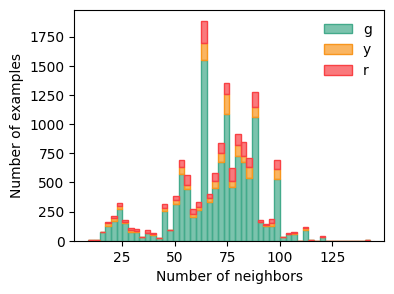

In [19]:
def get_neighbors(graph_data):
    n_neighbors = []
    for data in tqdm(graph_data, desc="Processing graph data", unit="material"):   # 遍历图数据列表（每个列表对应一个材料）
        N = data.pos.shape[0]  # 获取图中节点的数量
        for i in range(N):
            n_neighbors.append(len((data.edge_index[0] == i).nonzero()))  # 计算每个节点的邻居数
    return np.array(n_neighbors)

# 计算训练集、验证集和测试集的邻居数量
train_neighbors = get_neighbors(train_loader.dataset)  # 获取训练集的邻居数
valid_neighbors = get_neighbors(val_loader.dataset)  # 获取验证集的邻居数
test_neighbors = get_neighbors(test_loader.dataset)  # 获取测试集的邻居数

# 绘制邻居数量的直方图
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [train_neighbors, valid_neighbors, test_neighbors]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0, 2, 4)]
    y, bins, _ = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Number of examples')
ax.legend(frameon=False)

# 输出训练集、验证集和测试集的平均邻居数量
print('average number of neighbors (train/valid/test):', train_neighbors.mean(), '/', valid_neighbors.mean(), '/', test_neighbors.mean())


模型设计

In [20]:
class GatedGCNWithEdgeAttention(MessagePassing):
    def __init__(self, dim_node=5, dim_edge=50, epsilon=1e-5, learnable_att_weight=True):
        super().__init__(aggr='add')
        
        self.W_src = nn.Linear(dim_node, dim_node)
        self.W_dst = nn.Linear(dim_node, dim_node)
        self.W_e = nn.Linear(dim_edge, dim_edge)
        self.W_a = nn.Linear(dim_edge, dim_edge)
        self.W_u = nn.Linear(dim_node * 2 + dim_edge * 2, dim_edge)
        self.W_v = nn.Linear(dim_node * 2 + dim_edge * 2, dim_edge)
        
        self.att_weight = nn.Parameter(torch.Tensor(1, dim_edge * 2)) if learnable_att_weight else None
        self.att_bias = nn.Parameter(torch.Tensor(1))
        self.edge_bias = nn.Parameter(torch.Tensor(1, dim_edge))
        
        self.sigma = nn.Sigmoid()
        self.act = nn.LeakyReLU()
        self.norm_x = nn.LayerNorm(dim_node)
        self.norm_e = nn.LayerNorm(dim_edge)
        self.eps = epsilon
        self.reset_parameters()

    def reset_parameters(self):
        if self.att_weight is not None:
            nn.init.xavier_uniform_(self.att_weight)
        if self.att_bias is not None:
            nn.init.zeros_(self.att_bias)
        if self.edge_bias is not None:
            nn.init.zeros_(self.edge_bias)
            
        nn.init.xavier_uniform_(self.W_src.weight); self.W_src.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.W_dst.weight); self.W_dst.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.W_e.weight); self.W_e.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.W_a.weight); self.W_a.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.W_u.weight); self.W_u.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.W_v.weight); self.W_v.bias.data.fill_(0)

    def forward(self, x, edge_index, edge_angle, pre_edge_len):
        x = self.W_src(x)
        return self.propagate(edge_index, x=x, pre_edge_len=pre_edge_len, edge_angle=edge_angle)

    def message(self, x_j, edge_index, pre_edge_len, edge_angle):
        edge_attention = self.compute_edge_attention(x_j, pre_edge_len, edge_index)
        edge_attention = edge_attention + self.edge_bias.view(-1)
        sigma_a = self.sigma(edge_angle)
        a_sum = scatter(src=sigma_a, index=edge_index[0], dim=0 ,reduce='max')
        a_gated = sigma_a / (a_sum[edge_index[0]] + self.eps)
        return (edge_attention.view(-1, 1) * a_gated.view(-1, 1)) * self.W_dst(x_j)

    def compute_edge_attention(self, x_j, pre_edge_len, edge_index):
        edge_input = torch.cat([x_j, pre_edge_len], dim=-1)
        grouped_attention = scatter(edge_input @ self.att_weight.t() + self.att_bias, edge_index[0], dim=0, reduce='max')
        return F.softmax(grouped_attention, dim=1)  # 按每个节点归一化

    def update(self, x, aggr_out, edge_index, pre_edge_len, edge_angle):
        
        x = self.norm_x(x)
        pre_edge_len = self.norm_e(pre_edge_len)
        edge_angle = self.norm_e(edge_angle)
        
        pre_edge_weights = self.act(self.W_e(pre_edge_len))
        edge_angle_weights = self.act(self.W_a(edge_angle))
        combined_edge_weights = self.norm_e(pre_edge_weights * edge_angle_weights)
        
        row, col = edge_index
        weighted_edge_features = combined_edge_weights * aggr_out[row]
        aggregated_edges = scatter(weighted_edge_features, index=col, dim=0 ,reduce='max')
        updated_nodes = self.norm_x(aggregated_edges + x)
        
        z = torch.cat([x[edge_index[0]], x[edge_index[1]], edge_angle, pre_edge_len], dim=-1)
        
        edge_angle = edge_angle + self.act(self.norm_e(self.W_u(z)))
        pre_edge_len = pre_edge_len + self.act(self.norm_e(self.W_v(z)))
        
        return self.act(updated_nodes), edge_angle, pre_edge_len

    def propagate(self, edge_index, x, pre_edge_len, edge_angle):
        row, col = edge_index
        aggr_out = scatter(src=x[row], index=col, dim=0 ,reduce='max')
        return self.update(x, aggr_out, edge_index, pre_edge_len, edge_angle)

In [21]:
class MGModel(nn.Module):
    def __init__(self, dataset, hidden_dim=32, fc_num_layers=2, conv_num=1, dropout=0.1, sigma=1.0):
        super().__init__()
        
        self.dim_attr_node = dataset.x.shape[1]
        self.dim_type_node = dataset.type.shape[1]
        self.dim_edge = dataset.pre_edge_len.shape[1]
        
        self.hidden_dim = hidden_dim
        a = int(hidden_dim / 2)
        
        self.node_attr_fc = self.build_mlp(self.dim_attr_node, a, fc_num_layers, dropout)
        self.node_type_fc = self.build_mlp(self.dim_type_node, a, fc_num_layers, dropout)
        self.edge_len_fc = self.build_mlp(self.dim_edge, hidden_dim, fc_num_layers, dropout)
        self.edge_ang_fc = self.build_mlp(self.dim_edge, hidden_dim, fc_num_layers, dropout)
        
        self.gated_layer = self.init_conv(conv_num, hidden_dim, 1e-5)
        
        self.edge_out = nn.Linear(hidden_dim, 9)
        self.angle_out = nn.Linear(hidden_dim, 9)
        self.w_out = nn.Linear(18, 9)
        self.node_norm = nn.LayerNorm(hidden_dim)
        self.edge_norm = nn.LayerNorm(9)
        self.reset_parameters()

    def build_mlp(self, input_dim, hidden_dim, num_layers, dropout):
        num_layers = max(1,num_layers)
        layers = [nn.Linear(input_dim, hidden_dim), nn.LeakyReLU(), nn.Dropout(dropout), nn.BatchNorm1d(hidden_dim)]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(), nn.Dropout(dropout), nn.BatchNorm1d(hidden_dim)])
        return nn.Sequential(*layers)

    def reset_parameters(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def init_conv(self, conv_num, hidden_dim, epsilon):
        conv_num = max(1, conv_num)
        conv_list = nn.ModuleList()
        for _ in range(conv_num):
            conv_list.append(GatedGCNWithEdgeAttention(hidden_dim, hidden_dim, epsilon))
        return conv_list

    def process_node_features(self, dataset):
        node_features_a = self.node_attr_fc(dataset.x)
        node_features_b = self.node_type_fc(dataset.type)
        return torch.cat([node_features_a, node_features_b], dim=-1)

    def process_edge_features(self, dataset):
        edge_features_len = self.edge_len_fc(dataset.pre_edge_len)
        edge_features_ang = self.edge_ang_fc(dataset.edge_attr)
        return edge_features_len, edge_features_ang

    def forward(self, dataset):
        node_features = self.process_node_features(dataset)
        edge_features_len, edge_features_ang = self.process_edge_features(dataset)
        
        for conv_layer in self.gated_layer:
            node_features, edge_features_ang, edge_features_len = conv_layer(
                node_features, dataset.edge_index, edge_features_ang, edge_features_len
            )
        node_output = self.node_norm(node_features)
        edge_output = self.edge_norm(self.edge_out(edge_features_len))
        angle_output = self.angle_out(edge_features_ang)
        weight_edge = self.w_out(torch.cat([edge_output, angle_output], dim=-1))
        return node_output, weight_edge

In [22]:
class CustomCompose(nn.Module):
    def __init__(self, first, second):
        super().__init__()
        self.first = first
        self.second = second

    def forward(self, *input):
        x = self.first(*input)
        return self.second(x)

In [23]:
class Network(nn.Module):
    def __init__(self, in_dim, em_dim, irreps_in, irreps_out, irreps_node_attr, layers, mul, lmax, max_radius,
                 number_of_basis=10, radial_layers=1, radial_neurons=100, num_neighbors=1., num_nodes=1.,
                 reduce_output=True):
        super().__init__()
        self.mul = mul
        self.lmax = lmax
        self.max_radius = max_radius
        self.number_of_basis = number_of_basis
        self.num_neighbors = num_neighbors
        self.num_nodes = num_nodes
        self.reduce_output = reduce_output

        self.irreps_in = o3.Irreps(irreps_in) if irreps_in is not None else None
        self.irreps_hidden = o3.Irreps([(self.mul, (l, p)) for l in range(lmax + 1) for p in [-1, 1]])
        self.irreps_out = o3.Irreps(irreps_out)
        self.irreps_node_attr = o3.Irreps(irreps_node_attr) if irreps_node_attr is not None else o3.Irreps("0e")
        self.irreps_edge_attr = o3.Irreps.spherical_harmonics(lmax)
        self.input_has_node_in = (irreps_in is not None)
        self.input_has_node_attr = (irreps_node_attr is not None)
        self.em_r = nn.Linear(1, em_dim)
        self.em_c = nn.Linear(in_dim, em_dim)
        act = {1: torch.nn.functional.silu, -1: torch.nn.functional.leaky_relu}
        act_gates = {1: torch.sigmoid, -1: torch.nn.functional.silu}
        irreps = self.irreps_in if self.irreps_in is not None else o3.Irreps("0e")
        self.layers = nn.ModuleList()
        for _ in range(layers):
            irreps_scalars = o3.Irreps([
                (mul, ir) for mul, ir in self.irreps_hidden 
                if ir.l == 0 and tp_path_exists(irreps, self.irreps_edge_attr, ir)
            ])
            irreps_gated = o3.Irreps([
                (mul, ir) for mul, ir in self.irreps_hidden 
                if ir.l > 0 and tp_path_exists(irreps, self.irreps_edge_attr, ir)
            ])
            irreps_gates = o3.Irreps([(mul, "0e") for mul, _ in irreps_gated])
            
            gate = Gate(
                irreps_scalars, [act[ir.p] for _, ir in irreps_scalars],
                irreps_gates, [torch.sigmoid for _ in irreps_gates],
                irreps_gated
            )
            conv = Convolution(
                irreps, self.irreps_node_attr, self.irreps_edge_attr, gate.irreps_in,
                number_of_basis, radial_layers, radial_neurons, num_neighbors
            )
            irreps = gate.irreps_out
            self.layers.append(CustomCompose(conv, gate))
        self.layers.append(
            Convolution(irreps, self.irreps_node_attr, self.irreps_edge_attr, self.irreps_out,
                        number_of_basis, radial_layers, radial_neurons, num_neighbors)
        )

    def preprocess(self, data: dict):
        batch = data.get('batch', data['pos'].new_zeros(data['pos'].shape[0]))
        edge_index = data.edge_index
        edge_src, edge_dst = edge_index[0], edge_index[1]
        edge_vec = data['edge_vec']
        return batch, edge_src, edge_dst, edge_vec

    def forward(self, data: dict, node_output=None, weight_edge=None) -> torch.Tensor:
        batch, edge_src, edge_dst, edge_vec = self.preprocess(data)
        edge_length = edge_vec.norm(dim=1)
        edge_length_embedded = soft_one_hot_linspace(
            x=edge_length,
            start=0.0,
            end=self.max_radius,
            number=self.number_of_basis,
            basis='gaussian',
            cutoff=False
        ).mul(self.number_of_basis ** 0.5)
        edge_attr = smooth_cutoff(edge_length / self.max_radius)[:, None] * weight_edge
        symbol = self.em_c(data.type)
        node_features = node_output
        for layer in self.layers:
            node_features = layer(node_features, symbol, edge_src, edge_dst, edge_attr, edge_length_embedded)
        if self.reduce_output:
            return scatter(node_features, batch, dim=0).div(self.num_nodes ** 0.5)
        else:
            return scatter_mean(node_features, batch, dim=0)

In [24]:
class MGE3_Model(nn.Module):
    def __init__(self, dataset, in_dim, em_dim, irreps_in, irreps_out, irreps_node_attr, layers, mul, lmax, max_radius,
                 number_of_basis=10, radial_layers=1, radial_neurons=100, num_neighbors=1., num_nodes=1., dropout=0.1,
                 fc_num_layers=2, conv_num=1, sigma=1.0, reduce_output=True):
        super().__init__()
        self.mg_model = MGModel(dataset, hidden_dim=32, fc_num_layers=fc_num_layers, conv_num=conv_num,
                                dropout=dropout, sigma=sigma)
        self.network = Network(in_dim, em_dim, irreps_in, irreps_out, irreps_node_attr, layers, mul, lmax,
                               max_radius, number_of_basis, radial_layers, radial_neurons, num_neighbors,
                               num_nodes, reduce_output)

    def forward(self, data: dict) -> torch.Tensor:
        node_output, weight_edge = self.mg_model(data)
        final_node_output = self.network(data, node_output=node_output, weight_edge=weight_edge)
        return F.leaky_relu(final_node_output, negative_slope=0.002)

In [33]:
in_dim = 118
em_dim = 32
out_dim = 1

model = MGE3_Model(
    dataset=next(iter(train_loader))[0],
    in_dim=in_dim,
    em_dim=em_dim,
    irreps_in=f"{em_dim}x0e",
    irreps_out=f"{out_dim}x0e",
    irreps_node_attr=f"{em_dim}x0e",
    layers=2,       
    mul=32,
    lmax=2,
    max_radius=6.0,
    num_neighbors=train_neighbors.mean(),
    dropout=0.2,
    fc_num_layers=2,
    conv_num=6,
    sigma=1.0,
    reduce_output=True
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8144\1046099695.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(graph_path)  # 加载图数据
D:\Anaconda\

In [26]:
def get_min_max(dataloader_train):
    min_y = float('inf')
    max_y = -float('inf')
    for j, d in enumerate(dataloader_train):
        y = d.y
        min_y = min(min_y, y.min())
        max_y = max(max_y, y.max())
    return min_y, max_y

min_y, max_y = get_min_max(train_loader)

def normalize_target(y, min_y, max_y):
    return (y - min_y) / (0.1*(max_y - min_y))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8144\1046099695.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(graph_path)  # 加载图数据


In [27]:
def train(model, optimizer, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
          max_iter=101, scheduler=None, scheduler_exponential=None, device="cpu"):
    model.to(device)

    checkpoint_generator = loglinspace(0.2, 5)
    checkpoint = next(checkpoint_generator)
    start_time = time.time()

    try: model.load_state_dict(torch.load('./model/' + run_name + '.torch')['state'])
    except:
        results = {}
        history = []
        s0 = 0
        print("b")
    else:
        results = torch.load('./model/' + run_name + '.torch')
        history = results['history']
        s0 = history[-1]['step'] + 1
        print("a")
    
    for step in range(max_iter):
        model.train()
        loss_cumulative = 0.
        loss_cumulative_mae = 0.
        
        for j, d in tqdm(enumerate(dataloader_train), total=len(dataloader_train), bar_format=bar_format):
            d.edge_index = torch.tensor(d.edge_index)
            
            d.to(device)
            d.y = d.y.float()
            d.y = normalize_target(d.y, min_y, max_y)
            output = model(d)
            output = output.squeeze()
            d.y = torch.nan_to_num(d.y, nan=0.0)
            
            loss = loss_fn(output, d.y).cpu()
            loss_mae = loss_fn_mae(output, d.y).cpu()
            loss_em = 0.9 * loss + 0.1 * loss_mae
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()
            
            
            optimizer.zero_grad()
            torch.autograd.set_detect_anomaly(True)
            loss_em.backward()
            optimizer.step()

        end_time = time.time()
        wall = end_time - start_time

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step

            valid_avg_loss = evaluate(model, dataloader_valid, loss_fn, loss_fn_mae, device)
            train_avg_loss = evaluate(model, dataloader_train, loss_fn, loss_fn_mae, device)

            history.append({
                'step': s0 + step,
                'wall': wall,
                'batch': {
                    'loss': loss.item(),
                    'mean_abs': loss_mae.item(),
                },
                'valid': {
                    'loss': valid_avg_loss[0],
                    'mean_abs': valid_avg_loss[1],
                },
                'train': {
                    'loss': train_avg_loss[0],
                    'mean_abs': train_avg_loss[1],
                },
            })

            results = {
                'history': history,
                'state': model.state_dict()
            }

            print(f"Iteration {step+1:4d}   " +
                  f"train loss = {train_avg_loss[1]:8.4f}   " +
                  f"train loss_2 = {train_avg_loss[0]:8.4f}   " +
                  f"valid loss = {valid_avg_loss[1]:8.4f}   " +
                  f"valid loss_2 = {valid_avg_loss[0]:8.4f}   " +
                  f"elapsed time = {time.strftime('%H:%M:%S', time.gmtime(wall))}")

            output_dir = './model/'
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            with open(f'./model/{run_name}.torch', 'wb') as f:
                torch.save(results, f)

        if scheduler is not None:
            scheduler.step()

        if step >= warmup_steps and scheduler_exponential is not None:
            scheduler_exponential.step() 

In [28]:
def evaluate(model, dataloader, loss_fn, loss_fn_mae, device):
    model.eval()
    loss_cumulative = 0.
    loss_cumulative_mae = 0.
    start_time = time.time()
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.edge_index = torch.tensor(d.edge_index)
            d.to(device)
            d.y = normalize_target(d.y, min_y, max_y)
            output = model(d)
            output = output.squeeze()
            d.y = d.y.float()
            d.y = torch.nan_to_num(d.y, nan=0.0)
            
            loss = loss_fn(output, d.y).cpu()
            loss_mae = loss_fn_mae(output, d.y).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()
    return loss_cumulative/len(dataloader), loss_cumulative_mae/len(dataloader)

In [29]:
def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step*(1 - math.exp(-t*rate/step)))

In [30]:
opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.08)

warmup_steps = 5
initial_lr = 1e-6
max_lr = 5e-4

def lr_lambda(step):
    if step < warmup_steps:
        return initial_lr + (max_lr - initial_lr) * step / warmup_steps
    else:
        return 1.0

scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
scheduler_exponential = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.6)

loss_fn = torch.nn.MSELoss()   #torch.nn.HuberLoss(delta=0.3) 
loss_fn_mae = torch.nn.L1Loss()

In [31]:
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'

In [ ]:
run_name = 'model_eps_' + "01"
model.pool = True
train(model, opt, train_loader, val_loader, loss_fn, loss_fn_mae, run_name,max_iter=99, scheduler=scheduler_warmup, 
      scheduler_exponential=scheduler_exponential,device=device)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8144\110082731.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  try: model.load_state_dict(torch.load('./model/' + run

a


  0%|          | 0/75 [00:00<?, ?it/s]                                                                                 C:\Users\Administrator\AppData\Local\Temp\ipykernel_8144\1046099695.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issu

Iteration    1   train loss =   1.1931   train loss_2 =   4.6759   valid loss =   1.1844   valid loss_2 =   4.7787   elapsed time = 00:01:12


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]                                                                        


Iteration    2   train loss =   1.1920   train loss_2 =   4.6615   valid loss =   1.1840   valid loss_2 =   4.7767   elapsed time = 00:02:29


100%|██████████| 75/75 [01:19<00:00,  1.06s/it]                                                                        


Iteration    3   train loss =   1.2006   train loss_2 =   4.7140   valid loss =   1.1846   valid loss_2 =   4.7817   elapsed time = 00:03:53


100%|██████████| 75/75 [01:18<00:00,  1.05s/it]                                                                        


Iteration    4   train loss =   1.1923   train loss_2 =   4.6619   valid loss =   1.1855   valid loss_2 =   4.7779   elapsed time = 00:05:16


 88%|████████▊ | 66/75 [01:05<00:08,  1.06it/s]                                                                        

In [ ]:
history = torch.load('./model/' + run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

np.savetxt(run_name+'_MSE_loss.txt', np.column_stack((steps, loss_train, loss_valid)), fmt='%.8f', delimiter='\t')

fig, ax = plt.subplots(figsize=(4,4))

ax.plot(steps, loss_train, 'o-', label="Training", color='C0')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='C3')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
plt.tight_layout()
fig.savefig(run_name + '_loss.pdf')

In [ ]:
model.load_state_dict(torch.load('./model/'+run_name + '.torch', map_location=device)['state'])
model.pool = True

model.to(device)
model.eval()

In [ ]:
total_samples = sum(len(batch.y) for batch in test_loader)

# 根据样本数初始化 DataFrame
df = pd.DataFrame(index=range(total_samples), columns=['y_true', 'y_pred', 'mse'])

with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(test_loader), total=len(test_loader), bar_format=bar_format):
        d.edge_index = torch.tensor(d.edge_index)
        d.to(device)
        d.y = d.y.float()
        d.y = torch.nan_to_num(d.y, nan=0.0)
        d.y = normalize_target(d.y, min_y, max_y)
        output = model(d).squeeze()
        loss = F.mse_loss(output, d.y, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.y) - 1, 'y_pred'] = output.cpu().numpy()
        df.loc[i0:i0 + len(d.y) - 1, 'mse'] = loss
        df.loc[i0:i0 + len(d.y) - 1, 'y_true'] = d.y.cpu().numpy()
        i0 += len(d.y)

In [ ]:
# # 计算误差的绝对值
# df['error'] = abs(df['y_pred'] - df['y_true'])

# # 找到误差最大的索引
# max_error_index = df['error'].idxmax()

# # 删除误差最大 的一行
# df = df.drop(index=max_error_index).reset_index(drop=True)

In [ ]:
y_test = df['y_true'].to_numpy() 
y_pre = df['y_pred'].to_numpy()

y_pre = y_pre *  0.1*(max_y - min_y).numpy() + min_y.numpy()
y_test = y_test *  0.1*(max_y - min_y).numpy() + min_y.numpy()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

print("mean_absolute_error:",mean_absolute_error(y_test,y_pre))
print("mean_squared_error:",mean_squared_error(y_test,y_pre))
print("rmse:",sqrt(mean_squared_error(y_test,y_pre)))
print("r2:",r2_score(y_test,y_pre))

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(list(range(1, len(y_test) + 1)), y_test, label='True Values', marker='o')
plt.plot(list(range(1, len(y_pre) + 1)), y_pre, label='Predicted Values', marker='x')
plt.xlabel('Observation')
plt.ylabel('gap')
plt.xlim([1, len(y_test)])
plt.legend()
plt.title('True vs Predicted Values')
plt.show()

In [ ]:
y_test = pd.to_numeric(y_test, errors='coerce')
y_pre = pd.to_numeric(y_pre, errors='coerce')

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

errors = np.abs(np.array(y_test) - np.array(y_pre))
colors = np.interp(errors, (errors.min(), errors.max()), (0, 1))  # 归一化到 [0, 1]

colors_list = [(0.3, 0, 0.5), (1, 0.9, 0.6)]  # 深紫色到更浅的橘黄色
cmap = LinearSegmentedColormap.from_list('purple_lightorange', colors_list)


plt.figure(figsize=(8, 8))
scatter = plt.scatter(y_test, y_pre, c=colors, cmap=cmap, edgecolor='none')

# 添加参考线
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='darkblue', linestyle='--')

# 设置标签和标题
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 去掉网格线
plt.grid(False)

# 显示颜色条，并设置标签
cbar = plt.colorbar(scatter)

# 标注 R²、MAE 和 RMSE
# 假设这些值由变量 r2, mae, rmse 提供
r2 = r2_score(y_test,y_pre)
mae = mean_absolute_error(y_test,y_pre)
rmse = sqrt(mean_squared_error(y_test,y_pre))  

plt.text(0.95, 0.05, f'$R^2$ = {r2:.5f}\nMAE = {mae:.5f}\nRMSE = {rmse:.5f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# 显示图形
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

# 假设 y_test, y_pre 已经定义
errors = np.abs(np.array(y_test) - np.array(y_pre))
# 直接使用 viridis 的色彩映射
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(8, 8))
scatter = plt.scatter(y_test, y_pre, c=errors, cmap=cmap, edgecolor='none', s=50, alpha=0.8)

# 添加 1:1 参考线
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='gray', linestyle='--', linewidth=1)

plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)

# 显示颜色条
cbar = plt.colorbar(scatter, shrink=0.8, pad=0.02)
cbar.set_label('Absolute Error', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# 计算指标
r2 = r2_score(y_test, y_pre)
mae = mean_absolute_error(y_test, y_pre)
rmse = sqrt(mean_squared_error(y_test, y_pre))
plt.text(0.95, 0.05, f'$R^2$ = {r2:.5f}\nMAE = {mae:.5f}\nRMSE = {rmse:.5f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

# 假设 y_test 和 y_pre 已经定义
# 计算 Bland-Altman 分析所需数据
mean_values = (np.array(y_test) + np.array(y_pre)) / 2
diff_values = np.array(y_test) - np.array(y_pre)
mean_diff = np.mean(diff_values)
std_diff = np.std(diff_values)

# 设置科研风格
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6), dpi=300)

# 绘制散点图
plt.scatter(mean_values, diff_values, color='royalblue', alpha=0.6, edgecolor='k', label="Data Points")

# 画出均值线和一致性限界
plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
plt.axhline(mean_diff + 1.96 * std_diff, color='darkorange', linestyle='--', label='Upper Limit (+1.96 SD)')
plt.axhline(mean_diff - 1.96 * std_diff, color='darkorange', linestyle='--', label='Lower Limit (-1.96 SD)')

# 标注 R²、MAE、RMSE
r2 = r2_score(y_test, y_pre)
mae = mean_absolute_error(y_test, y_pre)
rmse = sqrt(mean_squared_error(y_test, y_pre))

plt.text(0.98, 0.02, f'$R^2$ = {r2:.5f}\nMAE = {mae:.5f}\nRMSE = {rmse:.5f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# 设置标题和标签
plt.title("Bland-Altman Plot: True vs Predicted Values", fontsize=14)
plt.xlabel("Mean of True & Predicted Values", fontsize=12)
plt.ylabel("Difference (True - Predicted)", fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.show()
